In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
import easygui

#filter_regions = ['Seychelles', 'Benin', 'Equatorial_Guinea','Tunisia','United_Republic_of_Tanzania', 'Burundi']

### Highest Density Interval Function

In [62]:


def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

### prepare data

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
countries = pd.read_csv(url,
                       usecols = ['dateRep',
                                  'cases',
                                  'countriesAndTerritories', 
                                  'continentExp'],
                       dayfirst = True,
                       parse_dates = ['dateRep'])

countries = countries[countries.continentExp == 'Africa']
countries.rename(columns = {'dateRep':'date','countriesAndTerritories':'country'}, inplace = True)

countries = countries.drop(columns = 'continentExp').set_index(['country','date']).squeeze().sort_index()


In [108]:
countries['Madagascar'].tail()

date
2020-06-24    84
2020-06-25    63
2020-06-26    42
2020-06-27    93
2020-06-28    83
Name: cases, dtype: int64

In [58]:
# path = 'C:\\Users\\Elvis\\Downloads\\superdatascience_tableau\\covid rt\\africa.csv'
# countries = pd.read_csv(path,
#                       usecols = ['date','cases','country'],
#                       dayfirst=True,
#                       parse_dates=['date'],
#                       index_col=['country','date'],
#                       squeeze=True).sort_index()

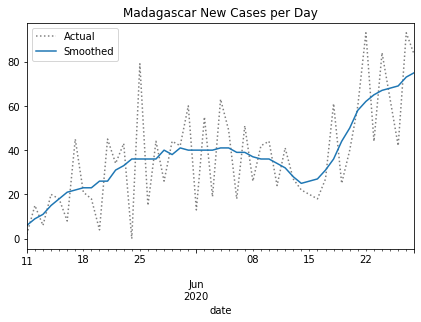

In [112]:
country_name = 'Madagascar'

def prepare_cases(cases, cutoff=5):
    smoothed = cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = cases.loc[smoothed.index]
    
    return original, smoothed

cases = countries.xs(country_name).rename(f"{country_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{country_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

## Function for Calculating the Posteriors
To calculate the posteriors we follow these steps:

Calculate  𝜆  - the expected arrival rate for every day's poisson process
Calculate each day's likelihood distribution over all possible values of  𝑅𝑡 
Calculate the process matrix based on the value of  𝜎  we discussed above
Calculate our initial prior because our first day does not have a previous day from which to take the posterior
Based on info from the cdc we will choose a Gamma with mean 7.
Loop from day 1 to the end, doing the following:
Calculate the prior by applying the Gaussian to yesterday's prior.
Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
Divide by the probability of the data (also Bayes' rule)

## function to obtain posteriors

In [113]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    R_T_MAX = 12                                          
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)      # We create an array for every possible value of Rt
    GAMMA = 1/7 # Gamma is 1/serial interval 1.# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
    
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.05)

### Ploting with credible HDI

In [114]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-06-24,1.31,0.88,1.66
2020-06-25,1.29,0.90,1.66
2020-06-26,1.28,0.88,1.63
2020-06-27,1.29,0.89,1.63
2020-06-28,1.28,0.89,1.62


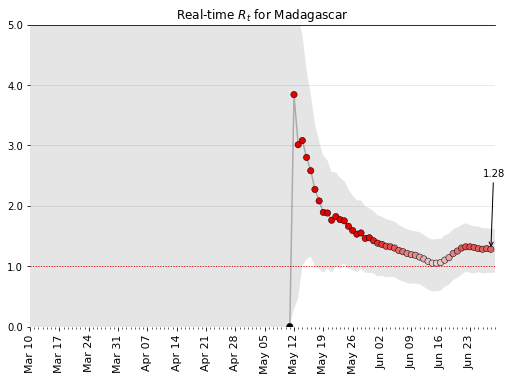

In [117]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, linestyle = ':',color = 'r', lw=1, label='$R_t=1.0$')#, alpha=.);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
#     ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-10'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')
    ax.annotate(s = str(values[-1].round(2)),
        xy = (index[-1],values[-1]),
       xytext = (index[-3],values[-1] + 1.2),
       arrowprops = {'arrowstyle':'->'})
    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, country_name)
ax.set_xticklabels(result.index.to_series(),rotation=90, fontsize=11)
ax.set_title(f'Real-time $R_t$ for {country_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#plt.savefig('rt_ghana_25.pdf')

### Choosing the optimal $\sigma$


In [10]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~countries.index.get_level_values('country').isin(filter_regions)
countries_to_process = countries.loc[targets]

results = {}

for country_name, cases in countries_to_process.groupby(level='country'):
    
    print(country_name)
    new, smoothed = prepare_cases(cases, cutoff=5)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=1)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of country name
    results[country_name] = result
    clear_output(wait=True)

print('Done.')

Done.


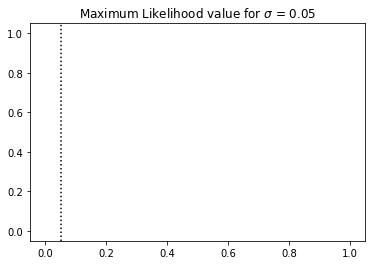

In [11]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each country's results and add the log likelihoods to the running total.
for country_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

## final results

In [88]:
final_results = None

for country_name, result in results.items():
    print(country_name)
    posteriors = result['posteriors'][max_likelihood_index]
    if ~posteriors.isnull().values.any():
        hdis_90 = highest_density_interval(posteriors, p=.9)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
        if final_results is None:
            final_results = result
        else:
            final_results = pd.concat([final_results, result])
        clear_output(wait=True)

print('Done.')

Done.


## plot for all regions

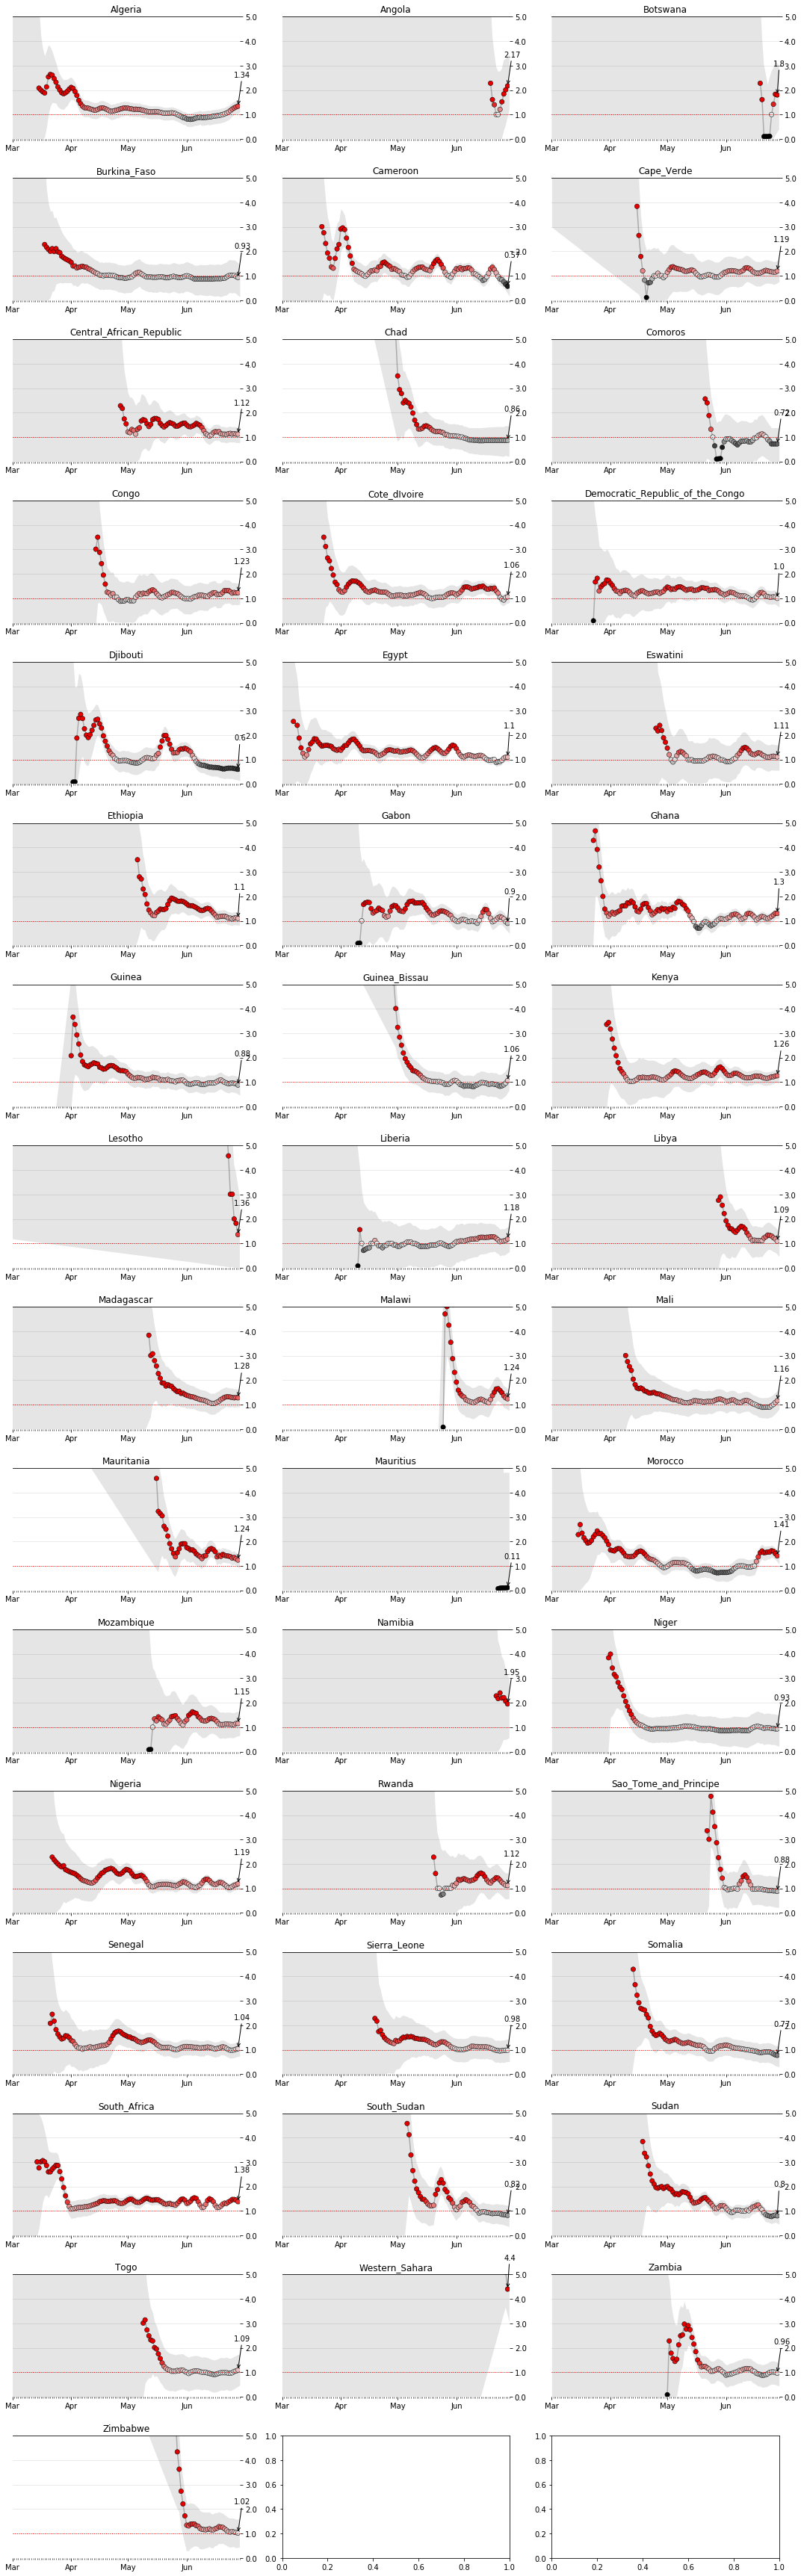

In [89]:
ncols = 3
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

In [90]:
# Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
final_results = final_results.groupby('country').apply(lambda x: x.iloc[1:].droplevel(0))

### export result to csv

In [91]:
final_results.to_csv('rt_africa.csv')

### plot of standings

In [92]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

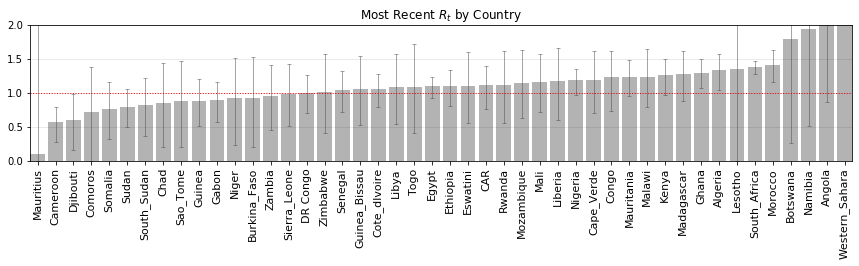

In [100]:
### filtered = final_results.index.get_level_values(0).isin(filter_regions)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

#    for bar, state_name in zip(bars, mr.index):
#        if state_name in no_lockdown:
#            bar.set_color(NONE_COLOR)
#        if state_name in partial_lockdown:
#            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'Sao_Tome_and_Principe':'Sao_Tome', 
                                           'Democratic_Republic_of_the_Congo':'DR Congo',
                                          'Central_African_Republic':'CAR'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='r', lw=1)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)

#    leg = ax.legend(handles=[
#                        Patch(label='Full', color=FULL_COLOR),
#                        Patch(label='Partial', color=PARTIAL_COLOR),
#                        Patch(label='None', color=NONE_COLOR)
#                    ],
#                    title='Lockdown',
#                    ncol=3,
#                    loc='upper left',
#                    columnspacing=.75,
#                    handletextpad=.5,
#                    handlelength=1)

#    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);


#plt.savefig('most_recent_rt_by_country_sort_ml.pdf')

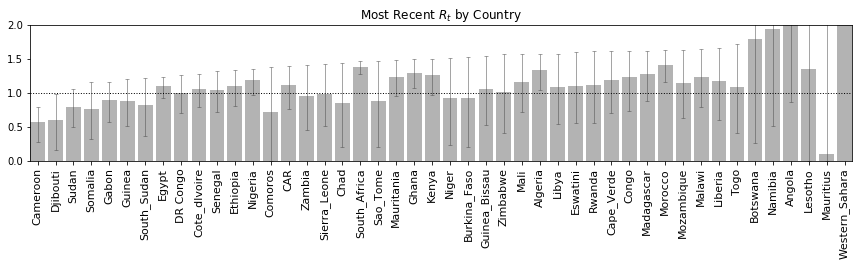

In [95]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

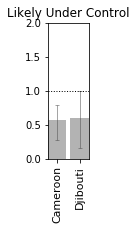

In [96]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

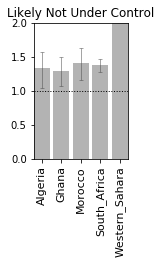

In [97]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
#ax.get_legend().remove()